In [32]:

import os
import sys
import re
import json
import numpy as np 
import pandas as pd
from pathlib import Path
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
sns.set_style('white')

import torch
from torchvision.utils import make_grid
# from umap import UMAP

print('pandas : ', pd.__version__)
print('numpy : ', np.__version__)
print('pytorch : ', torch.__version__)
print('python : ', sys.version)
# !python -V

dir_meta = Path('meta')
dir_meta.mkdir(exist_ok=True)

pandas :  1.3.5
numpy :  1.21.5
pytorch :  1.8.0
python :  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]


- notebook
    - pandas :  1.3.5
    - numpy :  1.21.5
    - pytorch :  1.8.0
    - python :  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]

##### 討論筆記


- 2022.0117 
    - 把每個物種海拔分布中點或平均值算出來 然後照海拔分群(文章裡應該有說每多少公尺分一段，然後在每一群內直接計算 feature space 的大小
        - 海拔的切法: 如果250一段 可從 -125~125, 125~375  
    - 因為 VSC 在訓練時就把所有值都加上約束了，就算把每個值都獨立看 也會看到幾乎一樣的結果
    - 要描述的東西是以物種為單位 點跟點之間的關係，不是看每個維度的分散程度
    - 多樣性低 會有差的是物種點佔據的 feature space 會明顯變小，所以你要嘛描述每個點到原點的距離分布 或是描述任意兩點間的距離的分布。
        - 至於分布如何描述 就至少有平均值 標準差 四分位差 boxblot whiskers max, min 這些東西可以用
    - 目標方法可以是很抽象的 
        - 譬如說目標是海拔段的物種外觀多樣性 那下一個最近的問題就是海拔怎麼切 多樣性要用什麼指標 然後就會回到手邊有怎樣的資料 可以達成哪些指標計算 最後才是回到程式上

### 研究假說
#### Benign environments promote thermal trait diversity

- Functional diversity沿緯度與海拔梯度的變化沒有定論

- Favorability hypothesis
    - 高緯度 高海拔
        - Climatic variability hypothesis： 耐冷又耐熱
        - Favorability hypothesis: 適應冷 就不能適應熱 Trade-offs hypothesis

    - 低緯度 低海拔
        - Climatic variability hypothesis： specialization (environmental filtering)
        - Favorability hypothesis: 種間變異大 （同一個assemblage內、種間競爭影響大）

- 預測
    - Thermal tolerance -functional trait
    - Range size


#### 從群聚層級檢視功能性多樣性
- 功能性多樣性(Functional diversit)沿緯度與海拔梯度的變化
    - Functional trait
        - TT(Thermal tolerance)
        - RS(Range size)
    - Morphology
        - 這裡的形態特徵是經過Autoencoder提取出來的抽象特徵，而非傳統人為主觀定義的
            - 抽象特徵(a.k.a. z /Latent space / Feature)
            - 以物種為單位呈現特徵空間(Feature Space)
                - 取物種均值/中位數(Dimension = (1,512))  

- 研究問題
    - 敘述性統計挖掘潛在關聯
        - 檢視形態特徵沿緯度與海拔梯度的變化
            - (按不同緯度)在不同海達下Feature Space的變異程度
        - 檢視不同功能特徵間彼此的關聯
            - 目前已分析RR與TS
            - 形態特徵與RS及TT的關聯
    
    - 預測
        - 找出具有預測1.海拔分布、2.耐溫能力的關鍵形態特徵


### 讀取資料、計算物種為單位的Feature Space

##### 讀取coding(latent space)

- note 正負值拆開成不同維度
    - 特徵是以0為對稱點 所以正負值被解釋為不同的特徵比較合理
    - back propagation 時，負的梯度遇上正的特徵值 或是相反 意義上都會非常不好解釋

In [33]:
coding = pd.read_csv('latent_space/vsc_epoch_31914/codes.csv', sep='\t', index_col=0 )
filename = coding.filename.apply(lambda str_ : Path(str_).stem.split('_cropped')[0])
coding = coding.iloc[:,:-1]

col = coding.columns.astype('uint16')
coding.columns = col
coding

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.001079,-0.000544,0.000399,-0.003642,0.000518,0.000561,-0.001321,-0.003015,0.003724,0.002218,...,0.000905,0.004727,0.003005,-0.002860,0.002981,-0.000168,-0.317842,-0.004001,0.005765,-0.003228
1,0.002735,0.002735,0.003984,-0.005105,0.000391,0.006046,-0.001291,0.004539,0.008044,-0.000786,...,-0.005432,0.004877,0.000755,-0.005382,-0.002671,0.002536,0.386901,-0.002686,0.005009,-0.002152
2,-0.003183,-0.000131,-0.004032,0.001230,-0.003498,0.000523,-0.000668,-0.000690,0.004566,0.002496,...,0.002488,-0.000839,-0.005443,0.000650,0.001565,0.002283,0.917296,0.000898,-0.002063,-0.002445
3,0.000472,0.005015,0.000905,0.001533,0.000057,-0.004833,0.000618,0.000556,0.002746,-0.000695,...,-0.004337,-0.000667,0.003901,-0.000396,0.004565,0.004297,-0.266727,0.005127,-0.002627,0.000675
4,0.000497,-0.000845,-0.000639,0.001082,-0.002412,-0.001428,-0.000601,0.002882,0.004398,-0.000045,...,-0.003754,0.001454,0.002621,0.002970,0.003609,-0.001059,1.142986,0.001799,0.000259,0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,0.001646,0.000607,0.001782,-0.001175,-0.000101,0.003103,0.000210,0.001348,-0.000828,0.003163,...,-0.002231,0.003434,-0.000442,-0.000222,0.003272,-0.000474,0.103783,0.001336,0.001721,-0.000449
8871,0.004085,0.001911,0.002930,-0.003200,0.001421,0.002434,-0.002131,0.003071,0.001643,-0.001244,...,-0.002081,0.003610,0.000924,-0.005030,0.002146,-0.000238,1.017337,0.001400,0.000349,0.001595
8872,0.001755,0.002030,0.000953,-0.003534,0.003475,0.003228,-0.001283,0.004413,0.007220,-0.001518,...,-0.002994,0.001752,0.000181,-0.000882,-0.001621,-0.002594,0.326988,0.000365,0.002700,-0.001363
8873,-0.000686,0.001456,0.008264,-0.002041,0.002064,0.001090,-0.003158,0.003685,0.002593,0.001769,...,-0.002412,0.008262,0.005356,0.000561,0.001693,-0.002856,-0.566896,-0.000610,0.002368,-0.002427


- 讀取並刪除破損及問題檔案 

In [34]:
dir_problemed = Path('../data/Problemed_data')
print(list(dir_problemed.iterdir()))
broken_over40 = list(dir_problemed.joinpath('Broken_over40').glob('*.png'))
print(len(broken_over40))
broken_over40 = set([path.stem.split('_cropped')[0] for path in broken_over40])
print(len(broken_over40))

broken_20_40 = list(dir_problemed.joinpath('Broken_20-40').glob('*.png'))
print(len(broken_20_40))
broken_20_40  = set([path.stem.split('_cropped')[0] for path in broken_20_40 ])
print(len(broken_20_40))

broken = broken_over40 | broken_20_40
print(len(broken))

df_broken =  pd.DataFrame(list(broken), index=range(len(broken)), columns=['broken'])

fname_broken = pd.merge(filename, df_broken,
        left_on='filename', right_on='broken', how ='left')
index_notbroken = fname_broken.query('broken.isnull().values').index.values
coding = coding.iloc[index_notbroken]
print(coding.shape)

[WindowsPath('../data/Problemed_data/Broken_10-20'), WindowsPath('../data/Problemed_data/Broken_20-40'), WindowsPath('../data/Problemed_data/Broken_over40'), WindowsPath('../data/Problemed_data/Cut'), WindowsPath('../data/Problemed_data/NGwimgs'), WindowsPath('../data/Problemed_data/problemed.csv'), WindowsPath('../data/Problemed_data/TERSI'), WindowsPath('../data/Problemed_data/篩選原則與流程.docx')]
82
81
241
241
316
(8562, 512)


##### 建立coding的metadate 
- 探索thermal與rangesize 資料
- ~~建立檔名與物種名及thermal、rangesize的關聯檔~~
    - 見data/meta_thermal_rangesize/get_meta.ipynb
    - 整理好的關聯檔為"df_ori_TTRS_all.csv'"

- 讀取檔名與TTRS的關聯檔

In [35]:
col_TTRS_sample_based = ['fname', 'No', 'Location', 'Family', 'Species', 'Altitude', 'W_length',
       'B_length', 'Dw(g)', 'CTmax', 'CTmin', 'Tmax', 'Tmin', 'Tmean', 'DTR'] 

col_TTRS_sp_based = ['fname', 'No', 'Location', 'Family', 'Species', 'Sample Size', 'TTRS_Elev_up', 'TTRS_Elev_low', 'TTRS_Elev_mid',
       'TTRS_RS', 'TTRS_W_length', 'TTRS_B_length', 'TTRS_Weight',
       'TTRS_CTmax', 'TTRS_CTmin', 'TTRS_CTrange', 'TTRS_Tmax', 'TTRS_Tmin',
       'TTRS_Tmean', 'TTRS_DTR']

In [36]:
df_imgs_TTRS = pd.read_csv('../data/meta_thermal_rangesize/meta/df_ori_TTRS_all.csv', index_col=0)
# df_imgs_TTRS.dropna(how='all')
# 去掉台灣資料(均為空值)，僅包含馬來西亞與中國資料
# df_imgs_TTRS = df_imgs_TTRS.query('No.notnull()')
df_imgs_TTRS

,fname,No,Location,Family,Species,Altitude,W_length,B_length,Dw(g),CTmax,...,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Aberrasine lichenshihi_male_FBG_10-IV-2015_SWu...,NaN,Taiwan,Erebidae,Aberrasine lichenshihi,NaN,NaN,NaN,NaN,NaN,...,9.122,7.582308,0.00340,NaN,NaN,NaN,29.739528,20.135378,23.956410,9.604150
1,Abraxas adilluminata_female_Biluxi_1-VII-2015_...,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
2,Abraxas adilluminata_female_Hewang_28-X-2015_d...,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
3,Abraxas adilluminata_female_MTTS1558_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
4,Abraxas adilluminata_female_MTTS302_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,860.0,9.80,7.14,0.0040,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.0035,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.0035,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,860.0,10.39,7.44,0.0031,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560


- 讀取已各樣本測量值為根據的資料
    - 台灣部分無資料


In [37]:
df_imgs_TTRS_sample_based = df_imgs_TTRS.query('No.notnull()', engine='python')[col_TTRS_sample_based]
df_imgs_TTRS_sample_based

,fname,No,Location,Family,Species,Altitude,W_length,B_length,Dw(g),CTmax,CTmin,Tmax,Tmin,Tmean,DTR
577,ARC01_SJTT0564_1_male,SJTT0564,China,Erebidae,SJ_ARC10,2000.0,33.30,21.52,0.12310,NaN,1.0,16.872565,9.317783,12.286201,7.554783
578,ARC01_SJTT0586_1_male,SJTT0586,China,Erebidae,SJ_ARC01,2000.0,31.31,20.52,0.07980,NaN,0.1,20.249839,10.111318,14.087058,10.138521
579,ARC01_SJTT0925_1_male,SJTT0925,China,Erebidae,SJ_ARC01,1536.0,35.22,22.29,0.09540,NaN,5.2,26.812227,16.849169,20.694877,9.963058
580,ARC02_SJRS00701_male,SJRS00701,China,Erebidae,SJ_ARC02,2856.0,27.32,19.65,0.08198,NaN,NaN,20.249839,10.111318,14.087058,10.138521
581,ARC02_SJRS00733_male,SJRS00733,China,Erebidae,SJ_ARC02,1864.0,29.94,23.47,0.13256,NaN,NaN,24.251990,15.451680,18.841415,8.800310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,860.0,9.80,7.14,0.00400,NaN,NaN,29.702681,19.610288,22.794524,10.092393
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.00350,NaN,-1.7,29.702681,19.610288,22.794524,10.092393
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.00350,NaN,-1.7,29.702681,19.610288,22.794524,10.092393
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,860.0,10.39,7.44,0.00310,NaN,-2.9,29.702681,19.610288,22.794524,10.092393


- 讀取以物種均值為根據的TTRS資料|

In [38]:
df_imgs_TTRS_sp_based = df_imgs_TTRS[col_TTRS_sp_based]
df_imgs_TTRS_sp_based 

,fname,No,Location,Family,Species,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Aberrasine lichenshihi_male_FBG_10-IV-2015_SWu...,NaN,Taiwan,Erebidae,Aberrasine lichenshihi,17.0,1110.0,343.0,726.5,767.0,9.122,7.582308,0.00340,NaN,NaN,NaN,29.739528,20.135378,23.956410,9.604150
1,Abraxas adilluminata_female_Biluxi_1-VII-2015_...,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
2,Abraxas adilluminata_female_Hewang_28-X-2015_d...,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
3,Abraxas adilluminata_female_MTTS1558_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
4,Abraxas adilluminata_female_MTTS302_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560


In [39]:

df_coding_sp_based = pd.DataFrame(filename).merge(df_imgs_TTRS_sp_based ,
               left_on='filename',
               right_on='fname',
               how='left'
               ).loc[:,"fname":]

assert df_coding_sp_based.query('fname.isnull()', engine='python').size == 0
df_coding_sp_based = df_coding_sp_based.iloc[index_notbroken]  # 選取翅型較完好的資料
df_coding_sp_based

## 檔名完全吻合，沒有空值

,fname,No,Location,Family,Species,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Not_id_yet_CARS1607,CARS1607,Malaysia,Geometridae,CA_RSGEO173,2.0,1066.0,796.0,931.0,270.0,7.810000,5.895000,0.002515,NaN,NaN,NaN,24.182177,19.147115,21.252225,5.035062
1,CATT1380_1,CATT1380,Malaysia,Erebidae,CA_LIT41,12.0,1374.0,509.0,941.5,865.0,16.979167,16.267500,0.033555,41.500000,4.900000,36.600000,23.142452,17.743606,20.059967,5.398846
2,NOC040_SJTT0415_1_male,SJTT0415,China,Noctuidae,SJ_NOC040,19.0,3579.0,2000.0,2789.5,1579.0,17.213158,15.001053,0.040791,39.087500,0.462500,38.625000,18.226008,10.069118,13.274664,8.156890
3,CARS1467,CARS1467,Malaysia,Pyralidae,CA_PYR29,28.0,1374.0,1372.0,1373.0,2.0,9.036429,10.045600,0.004444,NaN,1.400000,NaN,21.871878,15.995126,18.598129,5.876752
4,CARS2225,CARS2225,Malaysia,Crambidae,CA_RSCRA231,2.0,470.0,470.0,470.0,0.0,9.545000,10.370000,0.005880,NaN,NaN,NaN,26.085936,20.279590,22.749810,5.806346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,CRA11_SJTT2092_1_female,SJTT2092,China,Crambidae,SJ_CRA11,7.0,2612.0,2602.0,2607.0,10.0,11.752857,10.390000,0.008116,43.600000,3.433333,40.166667,21.561719,11.637813,15.693849,9.923906
8871,GEO131_SJTT2202_1_male,SJTT2202,China,Geometridae,SJ_GEO131,14.0,3579.0,2000.0,2789.5,1579.0,19.925714,12.546429,0.014088,39.485714,-1.566667,41.052381,21.294774,11.288172,15.213427,10.006602
8872,CATT1548_1,CATT1548,Malaysia,Erebidae,CA_LIT33,25.0,1959.0,470.0,1214.5,1489.0,8.589583,5.871667,0.002338,36.487500,-1.500000,37.987500,20.795676,16.016036,18.098152,4.779640
8873,Callopistria maillardi maillardi_male-2_800px,NaN,Taiwan,Noctuidae,Callopistria maillardi maillardi,7.0,1644.0,900.0,1272.0,744.0,16.167143,14.258571,0.023943,45.050000,-0.050000,45.100000,28.552698,19.029937,22.687887,9.522760


In [40]:
df_coding_sp_based.query('Location=="Taiwan"', engine='python').describe()

,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
count,545.000000,545.000000,545.000000,545.000000,545.000000,540.000000,545.000000,540.000000,327.000000,400.000000,260.000000,545.000000,545.000000,545.000000,545.000000
mean,20.607339,2209.667890,1431.442202,1820.555046,778.225688,21.156144,16.744560,0.063679,41.097547,1.620646,39.140709,22.405549,15.162724,18.023310,7.242825
std,37.455905,596.887979,695.745731,560.562280,650.964272,6.477187,4.928877,0.075037,2.436606,2.736179,2.996173,4.110278,3.094474,3.408026,1.189567
min,1.000000,900.000000,343.000000,722.000000,0.000000,8.695455,6.383871,0.002363,32.700000,-4.000000,24.700000,14.220765,8.023275,10.750687,5.513848
25%,3.000000,1734.000000,900.000000,1447.500000,210.000000,16.716304,13.092857,0.018440,39.658824,-0.200000,37.750000,19.902970,13.434708,15.947922,6.356534
50%,8.000000,2039.000000,1511.000000,1775.000000,732.000000,20.175550,16.025000,0.042725,41.000000,1.375000,39.381667,22.212620,15.435441,18.153612,6.773857
75%,21.000000,2960.000000,1995.000000,2184.500000,1190.000000,24.258000,19.370000,0.071793,42.580952,3.222500,40.770455,25.251359,17.235435,20.330487,8.046644
max,422.000000,3140.000000,2993.000000,3050.000000,2650.000000,51.950000,31.940000,0.595367,48.000000,14.600000,45.150000,31.079402,21.921056,25.469858,9.937991


- 檢視各地區有多少物種
    - Total Species :  2,515
        - after drop : 2,434
    - Location
        - China:        661
        - Malaysia:    1462
        - Taiwan:       309

In [41]:
print(f'Total Species : {df_imgs_TTRS.Species.nunique():,d}')
print(f'    after drop : {df_coding_sp_based.Species.dropna().nunique():,d}')
print('-'*50)
print(
    (df_coding_sp_based.groupby(['Location']).Species.nunique()
))
print('-'*50)


Total Species : 2,515
    after drop : 2,434
--------------------------------------------------
Location
China        661
Malaysia    1462
Taiwan       309
Name: Species, dtype: int64
--------------------------------------------------


- 檢視各物種與樣本數分布情況

Number of species only 1 sample : 1337


count    2432.000000
mean        3.503701
std         6.947413
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       119.000000
Name: fname, dtype: float64

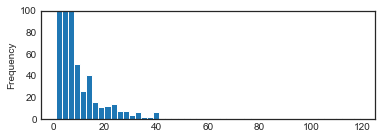

In [42]:
df_sp_sample = (df_coding_sp_based.groupby(['Location','Species'])
        .count().fname
        )
df_sp_sample.plot.hist(bins=50, ylim=(0, 100), figsize=(6,2))
;
print(f'Number of species only 1 sample : {df_sp_sample[df_sp_sample == 1 ].size}')
df_sp_sample.describe()

- 視覺化檢視取中位數/平均值後的物種樣貌
    - 確認處理上是否有誤
    - 順便比較取均值與取中位數的差別
    - 檔名包含各物種樣本數資訊

### 分析


    - load model

In [ ]:
from utils.networks import VSC
from utils.utils import load_model

# 指定GPU位置
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()  # 清除GPU記憶體暫存

channels= [32, 64, 128, 256, 512, 512]
model = VSC(cdim=3, hdim=512, channels=channels, image_size=256)

ck = 31914
ck_path = f'pretrained/vsc_epoch_{ck:d}.pth'
load_model(model, ck_path, map_location=device)

model = model.to(device)


    - define function

In [19]:
dir_save = Path(f"./results/latent")
dir_save.mkdir(parents=True, exist_ok=True)


def img_tensor_numpy(img: torch.tensor) -> np.ndarray:
    if img.dim() == 4 :
        img = img[0] 
    img_ = img.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    img = img_.transpose(1, 2, 0).clip(0, 1)            # (c,w,h) > (w,h,c)
    # image = image*std + mean                      # unnormalize
    return img

def im_convert(img, f_name=None, figsize:tuple=(16, 4), dir_save=dir_save, save=False):  
    img = img_tensor_numpy(img)
    plt.figure(figsize=figsize)
    plt.title(f'{f_name}')
    plt.axis('off')
    plt.imshow(image)
    
    if save:
        plt.savefig(dir_save.joinpath(f_name + '.jpg'),
                    bbox_inches='tight',
                   )
        print(f'{f_name} Saved', end='\r')
    plt.close()
    # fig_path =  f"./results/Feature_inverse"


### 特徵探索與視覺化

#### 內插檢視512維表徵的變化
- 使用Autoencoder模型學習到的表徵(representation)/coding，重現鱗翅目型態的主要成分
- ~~所有維度(512維)~~ => 重要維度(std > std_mean)


- 檢視z(latent vector 分布狀態)
    - 檢視z的分佈狀態
    - 可觀察到蛾類標本的表徵僅集中在少量維度(23/512維)

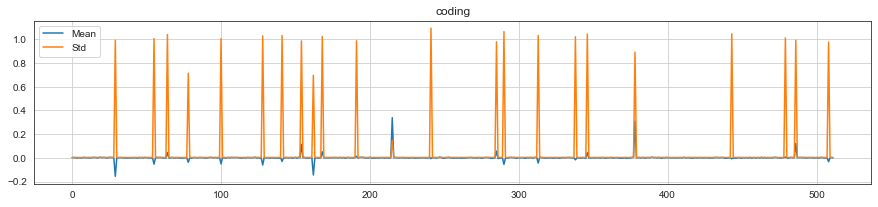

In [16]:
coding_mean = coding.mean()
coding_std = coding.std()
settings = dict(title='coding', figsize=(15,3), grid=True)
df = pd.DataFrame({'Mean':coding_mean,'Std':coding_std} )
df.plot(**settings);


             Mean         Std
count  512.000000  512.000000
mean     0.000881    0.045462
std      0.024738    0.200347
min     -0.156705    0.002014
25%     -0.001435    0.002905
50%      0.000064    0.003004
75%      0.001505    0.003116
max      0.338374    1.094318


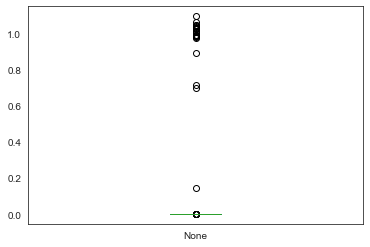

In [17]:
# coding_std.plot.hist(bins=50 );
print(df.describe())
coding_std.plot.box();

In [18]:
# Define sig dimensions :  std of coding > mean of std
sig_dim = df.query(f'Std > Std.mean()').index.values

print(f'Number of signuficant dimensions : {len(sig_dim)}')
print(f'Signuficant dimensions : {sig_dim}')


Number of signuficant dimensions : 23
Signuficant dimensions : ['29' '55' '64' '78' '100' '128' '141' '154' '162' '168' '191' '215' '241'
 '285' '290' '313' '338' '346' '378' '443' '479' '486' '508']


- 產出特徵的內差值
    - 針對顯著變化的維度計算其內差值
        - 0 +- 2*std 
        - z_base =  torch.zeros((1,512)。 
            - ~~基質採用各維度的均值(接近0)~~


In [ ]:
num = 30
c = 3

# for dim in sig_dim:
#     print(dim, end='\r')
#     # 產出該維度特徵內插值
#     # z_base = torch.Tensor(df.Mean).reshape(1,512)
#     z_base = torch.zeros((1,512)).to(device)
#     mean, std, *_ = df.loc[dim]
#     interplot_ = np.linspace(mean - c*std,  mean + c*std, num)
#     z_interplot = []
#     for l in interplot_:
#         z_base[0][int(dim)] = l
#         z_interplot.append(z_base.clone())
        
#     # 將該維度內插值送入decoder產生圖像
#     imgs_rec = []
#     with torch.no_grad():
#         for idx, z in enumerate(z_interplot):
#             print(idx, end='\r')
#             img_rec = model.decoder(z) 
#             imgs_rec.extend(img_rec)
#     im_convert(make_grid(imgs_rec, nrow=10, padding=2, pad_value=255),
#                f_name=f'Dimensions_{dim}', save=True)
    
# imgs_rec_all = torch.stack(imgs_rec)
# im_convert(make_grid(imgs_rec_all, nrow=num, padding=2, pad_value=255), 
#            f_name='Dimensions_All_Sig', figsize:tuple=(16, 12), save=True)


- 潛在空間(z)各維度內差圖
    - ~~row(每行): 各維度~~
    - cols(每列): 各維度內插值(由左上至右下: - 0 +)  


    ![Dimensions_479](imgs_jupyter/Dimensions_479.jpg)
    ![Dimensions_168](imgs_jupyter/Dimensions_168.jpg)

    
<!-- ![潛在空間(z)各維度內差圖](imgs_jupyter/latent_interplot.JPG) -->




#### ~~檢視z的std 變異程度~~

In [20]:
# 分別索引、建立三地區的coding值
# 僅檢視有顯著變化的維度
locations =  ["Malaysia", "Taiwan", "China"]

df_Location = df_coding_sp_based[['Location']].reset_index(drop=True)

idxs = [df_Location.query(f'Location=="{loc}"').index.values 
                             for loc in locations]

coding_list= [coding.reset_index(drop=True).loc[idx, sig_dim] for idx in idxs]


sample_size = [len(idx)for idx in idxs]
loc_size_ = list(dict(zip(locations, sample_size)).items())
loc_size = [f'{loc}_n={size}'  for loc, size in loc_size_]
loc_size

['Malaysia_n=4003', 'Taiwan_n=545', 'China_n=3995']

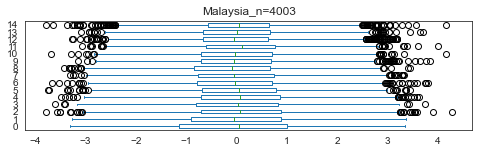

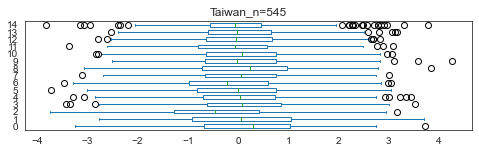

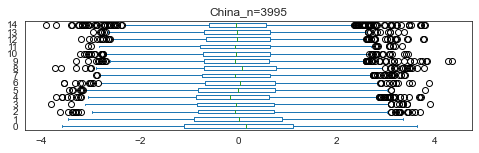

In [ ]:
figsize = (8,2)

for coding_, title in zip(coding_list,loc_size):
    coding_.plot.box(title=title,figsize=figsize, vert=False);


In [ ]:
# figsize = (6,3)
# columns_loc = dict(zip(range(3), loc_size))

# (pd.concat([coding_list[0].unstack(),
#             coding_list[1].unstack(),
#             coding_list[2].unstack(),],
#           axis=1,
#           names=locations
#           )
#  .rename(columns=columns_loc)
#  .plot.box(title='Range of Std in latent space' ,figsize=figsize)
# );


# print(f'sample size : {dict(zip(locations, sample_size))}') 


- 分地區檢視 lataent space的std 變異程度，沒有太大差異
    - 將所有維度打散成一維  

    ![Range of Std in latent space](imgs_jupyter/Range_of_Std_in_latent_space_unstack.png)  

- 討論
    - 將所有維度打散成一維，可能僅反應變異度最大的維度範圍
    - 以區域作分組可能太粗略，也許是看某類群在不同海拔?
    - 有沒有計算分散程度的指標?
    - 先用降維法進行處理，再檢視頭幾項重要維度

#### 降維分群探索
- 類群、海拔、地點?  很可能是反映類群

- 檢視維度空間多樣性
    - 地區
    - 海拔
    - 地區x海拔

- 以PCA降為視覺化可理解的三維檢視

In [ ]:
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pca = PCA(0.95)
embedding = pca.fit_transform(coding)

np.save('latent_space/embedding_PCA95.npy', embedding)
embedding = np.load('latent_space/embedding_PCA95.npy')

(8562, 18)


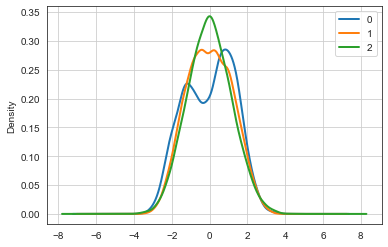

In [ ]:

df_embedding = pd.DataFrame(embedding)
print(embedding.shape)
# print(df_embedding.describe())
df_embedding.loc[:,:2].plot(kind="density", lw=2, grid=True);

In [ ]:
# (pd.DataFrame(
#     pca.explained_variance_ratio_.cumsum()
# )
#  .plot(title='Explained_variance_ratio', figsize=(6,3), grid=True )
# );
print('Number of dims for 95% explained_ratio : ', pca.explained_variance_ratio_.__len__())
pca.explained_variance_ratio_.cumsum()

Number of dims for 95% explained_ratio :  19


array([0.0812649 , 0.14791344, 0.21090369, 0.27186777, 0.33064062,
       0.38791134, 0.44264303, 0.49659032, 0.54937959, 0.59793608,
       0.64633911, 0.69424008, 0.73931049, 0.78286972, 0.82538228,
       0.86357145, 0.89838466, 0.92600386, 0.95198543])

In [ ]:
embedding_list= [df_embedding.loc[idx, :3] for idx in idxs]  #　['Malaysia', 'Taiwan', 'China]

In [ ]:
figsize = (8,1)
for embedding_, title in zip(embedding_list,loc_size):
    embedding_.loc[:,:2].plot.box(title=title,figsize=figsize, vert=False);

- 檢視PCA後embedding前三軸的數值變化範圍  
    - 台灣的範圍略小，可能只是樣本數較少?  
    
    ![Malaysia](imgs_jupyter/Range_of_Std_in_latent_space_Malaysia.png)  

    ![Taiwan](imgs_jupyter/Range_of_Std_in_latent_space_Taiwan.png)  

    ![China](imgs_jupyter/Range_of_Std_in_latent_space_China.png)

- 檢視PCA降維後各軸的變化

In [ ]:

linspace = 11
q = .01
upper = np.quantile(embedding, axis=0, q=(1-q) )
lower = np.quantile(embedding, axis=0, q=q)
# base = np.zeros((linspace, 3))
mean = np.mean(embedding, axis=0)
base = np.ones((linspace, 3)) * mean               # 各軸背景值採用該軸平均

for d in [0, 1, 2]:
    reducer_ = base.copy()  
    reducer_[:,d] = np.linspace(lower[d], upper[d], linspace)
    
    if d==0: 
        embedding_linespace = reducer_.reshape(1, linspace, -1)
    else:
        embedding_linespace = np.vstack((embedding_linespace, reducer_.reshape(1, linspace, -1)))
print("interpolation of embedding features: ", embedding_linespace.shape)

interpolation of embedding features:  (3, 11, 3)


In [ ]:
for d in [0, 1, 2]:
    embedding_inv = pca.inverse_transform(embedding_linespace[d])
    if d==0: 
        features_linespace = embedding_inv.reshape(1, linspace, -1)
    else:
        features_linespace = np.vstack(
            (features_linespace, embedding_inv.reshape(1, linspace, -1))
        )
        
print("Inverse of interpolated embedding features: ", features_linespace.shape)

Inverse of interpolated embedding features:  (3, 11, 512)


In [ ]:
features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
with torch.no_grad():
    for d in [0, 1, 2]:
        if d==0:
            rec =  model.decoder(features_linespace[d]).reshape(1, linspace, 3, 256, 256) 
        else:
            rec = torch.cat(
                ( rec, 
                 model.decoder(features_linespace[d]).reshape(1, linspace, 3, 256, 256) )
            )
print(rec.shape)

torch.Size([3, 11, 3, 256, 256])


In [ ]:
# fig_path =  f"./results/Feature_inverse"
def im_convert_PCA(tensor, f_name=None, subtitle=None, save=False, fig_root:Path =None, figsize=(12,3)):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0).clip(0,1)              # (c,w,h) > (w,h,c)
    plt.figure(figsize=figsize)
    plt.title(f'{f_name}', fontsize=24)
    plt.imshow(image)
    
    if save:
        fig_path =  fig_root.joinpath(f_name + ".jpg")
        plt.savefig(fig_path, bbox_inches='tight')
        print(f'{fig_path} Saved')
    plt.close()

dir_PCA =  Path(f"results/PCA")
dir_PCA.mkdir(exist_ok=True, parents=True)
im_convert(make_grid(rec.view(-1, 3, 256, 256), nrow=linspace, pad_value=255), 
           f_name=f"PCA_Inversed_Features_3Axis",  
           save=True , dir_save=dir_PCA, figsize=(18, 4))


- PCA前三軸視覺化
    - 前三軸解釋力占21%  
       
    ![](imgs_jupyter/PCA_Inversed_Features_3Axis.jpg)

##### UMAP 降維視覺化

In [ ]:
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

# sns.set(style='white', context='notebook', rc={'figure.figsize':(16,12)})

In [ ]:
n_components = 3 
n_neighbors = 500
metric='cosine'

    -  這邊是將已經透過PCA降維後的embedding丟入UMAP，而不是放入原本的codingm(z)
        - 目的是先透過PCA線性降維去除無用的維度降低運算量
        - 參考精通機器學習


In [ ]:
# 
reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, verbose=True, metric=metric)
# embedding_umap = reducer.fit_transform(embedding)

save_path = f'latent_space/embedding_UMAP_{n_components}D_{n_neighbors}_{metric}.npy'
# np.save(save_path, embedding_umap)
embedding_umap = np.load(save_path)
# print(f'{root} saved', end='\r') 

UMAP(angular_rp_forest=True, metric='cosine', n_components=3, n_neighbors=500, verbose=True)
Mon Jan 17 15:30:20 2022 Construct fuzzy simplicial set
Mon Jan 17 15:30:20 2022 Finding Nearest Neighbors
Mon Jan 17 15:30:20 2022 Building RP forest with 10 trees
Mon Jan 17 15:30:20 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Mon Jan 17 15:32:00 2022 Finished Nearest Neighbor Search
Mon Jan 17 15:32:19 2022 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:26]


Mon Jan 17 15:32:54 2022 Finished embedding


(8562, 19)


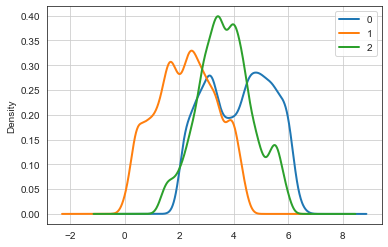

In [ ]:

df_embedding = pd.DataFrame(embedding_umap)
# print(embedding.shape)
# print(df_embedding.describe())
df_embedding.loc[:,:2].plot(kind="density", lw=2, grid=True);

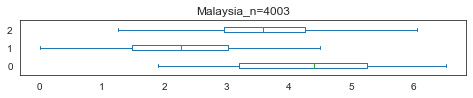

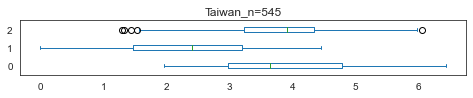

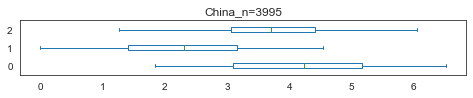

In [ ]:
embedding_list= [df_embedding.loc[idx, :3] for idx in idxs]  #　['Malaysia', 'Taiwan', 'China]
figsize = (8,1)
for embedding_, title in zip(embedding_list,loc_size):
    embedding_.loc[:,:2].plot.box(title=title,figsize=figsize, vert=False);

---


#### 檢視氣候變異與型態多樣性間的關聯- 找出關鍵特徵


##### 檢視在不同海拔/溫度下的表徵多樣性
##### 耐溫能力(耐溫範圍、耐溫上、下界)與型態的關係
##### 建立下游任務: eg: 海拔、耐溫範圍預測
- 檢視對應之下游任務中，模型主要反映的區域
        - 特徵圖(feature map)中，對於類別目標改變而有較大反應的像素位置(即gradcam之概念)


### 檢視形態特徵沿緯度與海拔梯度的變化

#### 建立以物種為單位的特徵值

- 物種特徵中位數/均值計算步驟
    - ~~使用for in~~
        - ~~取得各物種的index位置~~
            - 資料格式 : {sp : indexs}
        - ~~根據 key, index 計算各維度數值的中位數~~
    - 使用.groupby('Species').agg(np.median)

In [43]:
col = ['Location','Species',]
df_coding_sp_median = (df_coding_sp_based[col].merge(coding,
                              left_index=True, right_index=True,)
                       .groupby('Species').agg(np.median))

# df_coding_sp_median.to_csv('meta/df_coding_sp_median.csv')


In [44]:
# 產出各物種特徵
dir_sp_median = Path('results/Species_Feature_Median') 
dir_sp_median.mkdir(exist_ok=True, parents=True)

# with torch.no_grad():
#     for idx, (sp, z) in  enumerate(df_coding_sp_median.iterrows()):
#         print(f'{idx}, {sp:40s} ',end='\r' )
#         z = torch.Tensor(z).reshape(1,-1) # (512,) > （1,512）
#         img_rec = model.decoder(z)
        
#         img_rec_ = img_tensor_numpy(img_rec)
#         img_rec_ = (img_rec_*255).astype(np.uint8)
#         img = Image.fromarray(img_rec_)
#         img.save(dir_sp_median.joinpath(f'{sp}_median_n{len(indexes)}'  + '.jpg'))


- 檢視視覺化呈現重建的物種(取中位數)
    - 少數有輪廓崩潰的情況，部分背景常有雜訊，可能訓練時間仍不夠久  
    
![sp_feature_median.JPG](imgs_jupyter/sp_feature_median.JPG)

#### 按緯度、海拔呈現特徵空間(Feature Space)


- y軸 : feature space
    - 每個物種一個資料單位。物種的海拔分布取中位數
        - 資料形狀為(512,)的高維度
    - 檢視Functional richness沿緯度與梯度變化
        - Functional richness (FRic) is the amount of functional space occupied by a community. 
- x軸: 海拔
        - 海拔分組分別用每 250m或100m當成組中點切分。
            - 生一個欄位 內容是(mean_elev + (100 or 250) / 2) // (100 or 250))
            - interval=250 : (0-125]、(125-375)、...。
            - interval=100 : (0-50]、(50-150)、...。
- 分群描述與計算方式
    - 按海拔分群後， 每組會得到由許多物種的點(n,512)
    - 以箱型圖boxplot 呈現各海拔資料分佈
    - 距離指標('euc' vs 'cosine')
        - 經過vsc得到的z已經正歸化約束在 mean ~ 0, std ~ 1的分布範圍，
            - 直接看euc距離可以反映型值的變異程度(與原點比、或兩兩間比較)
            - cosize距離則反映物種間相似程度的幾何意義   
            ![](imgs_jupyter/distance_plot.png)  
            
    1. 計算各(海拔分)組，群內資料點與原點的距離
        - shape=(n,1) 
    2. 計算各(海拔分)組，群內所有資料點間彼此距離(任2點距離) 
        - 去中心化，與選擇的中心點位置無關 
   
        
- [參考資料]
    - [Calculate Similarity — the most relevant Metrics in a Nutshell](https://towardsdatascience.com/calculate-similarity-the-most-relevant-metrics-in-a-nutshell-9a43564f533e)
    - paired_distance 點與點距離計算參考sklearn文件 [Pairwise metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
        - pairedwised_distance
            - pairedwised_distance(X, {Y})
            - 如果沒有Y 會得到斜對角矩陣，計算任意量點間距離return (n,n) # 得到斜對角矩陣，對角線為0
            - 如果放入Y，例如原點np.zeros(n,1)，計算所有點與原點的距離 return (n,1)

In [45]:
df_TTRS_sp_based = pd.read_csv('meta/210607_CSV_All_Species_based.csv')

In [46]:
# 檢視各區物種分布中位的海拔分布
print(
df_TTRS_sp_based.groupby(['Location']).TTRS_Elev_mid.aggregate(['min', 'max', 'mean', 'median'])
)

df_coding_sp_based.groupby(['Location']).TTRS_Elev_mid.aggregate(['min', 'max', 'mean', 'median'])
#  台灣資料還不齊全，統計範圍會有差

            min     max        mean  median
Location                                   
China     860.0  4152.0  2027.68006  2000.0
Malaysia  140.0  1959.0  1078.27821  1066.0
Taiwan    343.0  3050.0  1602.51556  1574.5


,min,max,mean,median
Location,,,,
China,860.0,4152.0,2272.919858,2219.5
Malaysia,140.0,1959.0,1109.265813,1066.0
Taiwan,722.0,3050.0,1820.555046,1775.0


In [47]:
# 取得海拔分組標籤 _根據df_TTRS_sp_based按地區

col = ['Location', 'Family', 'Species',
       'TTRS_Elev_mid', 'TTRS_RS',  'TTRS_CTrange']
locations = ["Malaysia", "Taiwan", "China"]


# by absolute interval
step = 250

start = int(step/2)
alt_upper = int(df_coding_sp_based.TTRS_Elev_mid.max())
end = int(np.ceil(alt_upper/step) +1) * step
print('alt_upper : ', alt_upper) 
# print(start, end)
bins = [0] + list(range(start, end, step))
print(f'bins from {bins[0]} ~ {bins[-1]}, group : {len(bins)-1}')

alt_upper :  4152
bins from 0 ~ 4375, group : 18


In [48]:
df_alt_labels = pd.cut(df_TTRS_sp_based['TTRS_Elev_mid'], bins).rename('Alt')

# 將alt_label加入原資料    
col.insert(0, 'Alt')
df_TTRS_Alt_label = df_TTRS_sp_based.merge(df_alt_labels, 
                                           left_index=True, right_index=True)[col]

loc_bins = {}
for loc, group in  df_TTRS_Alt_label.groupby(['Location']).Alt:
    bin_ = group.unique().sort_values()
    loc_bins[loc] = bin_
    print(f'{loc:8s} : \n\t{bin_.min(), bin_.max()}')

df_TTRS_Alt_label

China    : 
	(Interval(625, 875, closed='right'), Interval(4125, 4375, closed='right'))
Malaysia : 
	(Interval(125, 375, closed='right'), Interval(1875, 2125, closed='right'))
Taiwan   : 
	(Interval(125, 375, closed='right'), Interval(2875, 3125, closed='right'))


,Alt,Location,Family,Species,TTRS_Elev_mid,TTRS_RS,TTRS_CTrange
0,"(1875, 2125]",Malaysia,Geometridae,CA_Abaxas_sp2,1959.0,0,35.000000
1,"(875, 1125]",Malaysia,Erebidae,CA_AGA01,940.5,863,30.100000
2,"(875, 1125]",Malaysia,Erebidae,CA_AGA02,984.5,163,NaN
3,"(1625, 1875]",Malaysia,Erebidae,CA_AGA03,1800.0,0,NaN
4,"(1125, 1375]",Malaysia,Erebidae,CA_AMATA01,1138.5,471,39.200000
...,...,...,...,...,...,...,...
3173,"(2625, 2875]",China,Drepanidae,SJ_THY15,2789.5,1579,40.319780
3174,"(2125, 2375]",China,Drepanidae,SJ_THY16,2360.0,992,NaN
3175,"(2375, 2625]",China,Drepanidae,SJ_THY17,2428.0,856,36.500000
3176,"(2375, 2625]",China,Uraniidae,SJ_URA01,2519.5,1311,40.366667


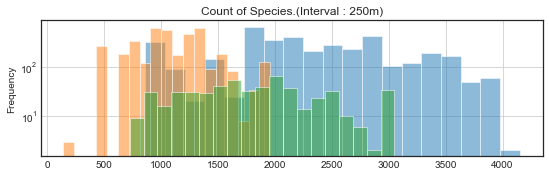

In [49]:
# 檢plot 視海拔分組的頻率分布
setting = dict(bins=len(bins), figsize=(9,2.5), alpha=0.5, logy=True, grid=True,
               title=f'Count of Species.(Interval : {step}m)')
(df_coding_sp_based.groupby(['Location']).TTRS_Elev_mid
 .plot.hist(**setting)
);


In [50]:
# 檢視海拔分組的頻率分布
alt_loc_count = df_TTRS_Alt_label.groupby(['Location','Alt']).count().Species.sort_index().unstack(level=0)
alt_loc_count[::1]

Location,China,Malaysia,Taiwan
Alt,,,
"(0, 125]",0,0,0
"(125, 375]",0,3,15
"(375, 625]",0,221,43
"(625, 875]",153,194,40
"(875, 1125]",4,537,153
"(1125, 1375]",20,312,102
"(1375, 1625]",44,170,163
"(1625, 1875]",96,42,114
"(1875, 2125]",78,63,148


- plot 海拔分群與樣本數
    - 250m 
        ![](imgs_jupyter/alt_count_250m.png)
    - 100m
        ![](imgs_jupyter/alt_count_100m.png)

- muliindex備忘:
    - [multiindex的排序對效能的影響](https://stackoverflow.com/questions/54307300/what-causes-indexing-past-lexsort-depth-warning-in-pandas)
    - [multiindex的索引](https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe)


In [51]:
# 在coding_sp_median 建立 index:['location', 'alt_label']、整理成dataframe格式

col = ['Location','Species',]
df_coding_sp_median = (df_coding_sp_based[col].merge(coding,
                              left_index=True, right_index=True,)
                       .groupby('Species').agg(np.median))

print(df_coding_sp_median.shape)   # index為sp

*_, dim = df_coding_sp_median.shape
print(df_TTRS_Alt_label.columns.values)

col = ['Location','Alt','Species', *range(dim)]

# df_coding_sp_median
# 增加loc 、 alt_label欄位
df_coding_sp_median = (df_coding_sp_median.merge(df_TTRS_Alt_label,
                          left_index=True,
                          right_on='Species',
                          how='left' 
                          )[col]
                       .dropna(subset=['Location'])
                       .set_index(['Location','Alt','Species']))

print(df_coding_sp_median.shape)

print(df_coding_sp_median.index.is_monotonic_increasing)
df_coding_sp_median = df_coding_sp_median.sort_index()

print(df_coding_sp_median.index.is_monotonic_increasing)
df_coding_sp_median


(2434, 512)
['Alt' 'Location' 'Family' 'Species' 'TTRS_Elev_mid' 'TTRS_RS'
 'TTRS_CTrange']
(2432, 512)
False
True


0         1    \
Location Alt          Species                                              
China    (625, 875]   SJ_BOM01                        0.001436  0.001065   
                      SJ_CRA05                       -0.001585 -0.000389   
                      SJ_CRA06                        0.004453  0.002803   
                      SJ_CRA09                        0.000651 -0.001003   
                      SJ_CRA13                       -0.000123 -0.001918   
...                                                        ...       ...   
Taiwan   (2875, 3125] Odontopera bilinearia subarida  0.001975 -0.002632   
                      Palpita asiaticalis             0.007033  0.005034   
                      Pseudodeltote formosana        -0.001246 -0.004350   
                      Thyas coronata                 -0.000442  0.000428   
                      Thyas juno                      0.002419  0.001362   

                                                           2         3    \
Location Alt          Species                                              
China    (625, 875]   SJ_BOM01                        0.002573 -0.002309   
                      SJ_CRA05                        0.001414  0.003182   
                      SJ_CRA06                        0.002501 -0.003294   
                      SJ_CRA09                        0.002133 -0.000072   
                      SJ_CRA13                        0.000731 -0.002790   
...                                                        ...       ...   
Taiwan   (2875, 3125] Odontopera bilinearia subarida  0.001436 -0.001243   
                      Palpita asiaticalis             0.005845 -0.004962   
                      Pseudodeltote formosana        -0.001048 -0.002792   
                      Thyas coronata                  0.000371 -0.003158   
                      Thyas juno                      0.002368 -0.002349   

                                                           4         5    \
Location Alt          Species                                              
China    (625, 875]   SJ_BOM01                       -0.000117  0.000866   
                      SJ_CRA05                       -0.003164 -0.000577   
                      SJ_CRA06                        0.002020  0.003348   
                      SJ_CRA09                       -0.003021  0.001627   
                      SJ_CRA13                        0.000379 -0.000172   
...                                                        ...       ...   
Taiwan   (2875, 3125] Odontopera bilinearia subarida -0.003001 -0.000472   
                      Palpita asiaticalis             0.003850  0.005853   
                      Pseudodeltote formosana        -0.002905 -0.001063   
                      Thyas coronata                 -0.000953  0.000311   
                      Thyas juno                     -0.000409 -0.000547   

                                                           6         7    \
Location Alt          Species                                              
China    (625, 875]   SJ_BOM01                       -0.000743  0.001050   
                      SJ_CRA05                       -0.000073  0.000337   
                      SJ_CRA06                       -0.002542  0.000165   
                      SJ_CRA09                       -0.002540 -0.000704   
                      SJ_CRA13                       -0.001064  0.000765   
...                                                        ...       ...   
Taiwan   (2875, 3125] Odontopera bilinearia subarida -0.002180 -0.000308   
                      Palpita asiaticalis            -0.005218  0.004037   
                      Pseudodeltote formosana        -0.001076 -0.003809   
                      Thyas coronata                 -0.001743 -0.000208   
                      Thyas juno                     -0.001147  0.003189   

                                                           8         9    ...  \
Location Alt          

##### Distances- from 0

In [52]:
from sklearn.metrics import pairwise_distances

In [294]:
# 與0的距離
metric="euclidean"  # "euclidean"
distances_matrix = pairwise_distances(df_coding_sp_median, np.zeros((1,512)), metric=metric)
print(distances_matrix.shape)

colname = 'Distance_0'

df_dis_0 = pd.DataFrame(distances_matrix,            
                      index= df_coding_sp_median.index,
                    #   columns=[colname]
                      ).set_axis([colname], axis=1)
df_dis_0

(2432, 1)


Distance_0
Location Alt          Species                                   
China    (625, 875]   SJ_BOM01                          1.722797
                      SJ_CRA05                          2.636947
                      SJ_CRA06                          3.482297
                      SJ_CRA09                          2.866449
                      SJ_CRA13                          3.273301
...                                                          ...
Taiwan   (2875, 3125] Odontopera bilinearia subarida    4.169231
                      Palpita asiaticalis               3.543413
                      Pseudodeltote formosana           4.816611
                      Thyas coronata                    3.578747
                      Thyas juno                        3.802364

[2432 rows x 1 columns]

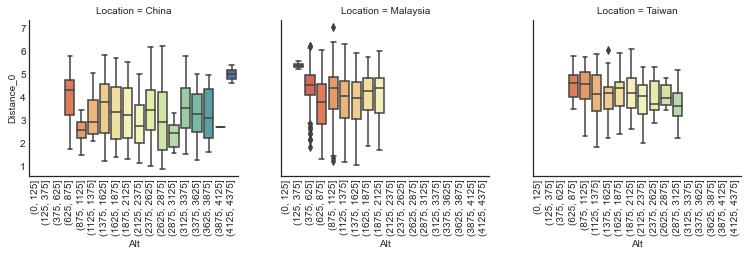

In [54]:
# plot boxplot

def plot_boxplot(df_dis,colname):
    ax = sns.catplot(x="Alt", y=colname, data=df_dis.reset_index(), 
                    col="Location", 
                    # hue="Alt_label",
                    # color='w' ,
                    # orient="h", height=2, aspect=3, palette="Set3",
                    # kind="violin", dodge=True, cut=0, bw=.2,
                    kind="box", height=3, 
                    aspect=1.2 if step==250 else 1.6,
                    palette= sns.color_palette("Spectral", n_colors=len(bins)-1)
                    )
    ax.set_xticklabels(
        # ax.get_xticklabels(), 
        rotation=90, 
        ha="center"
        );

plot_boxplot(df_dis_0,colname)

##### Pairwise_distances- All data

In [55]:
# 按地點、海拔分組計算 組內所有資料兩兩間距離
colname = 'PW_Distance_all'
metric="euclidean"  # "euclidean"
df_pwd = (df_coding_sp_median.groupby(['Location', 'Alt'])
              .apply(
                  lambda x: pairwise_distances(x, metric=metric)
                  )
              .rename(colname)
            #   .set_axis([colname], axis=1)
              # .reset_index()
              )

# 對角線矩陣取值
def get_tril(dis_matrix:np.ndarray)->np.ndarray:
    dis_matrix = np.tril(dis_matrix, k=-1)                       #  取矩陣斜對角下半部
    dis_matrix =  np.where(dis_matrix==0, np.nan,  dis_matrix)   #  assign 0 as np.nan
    return dis_matrix.astype(np.float)

df_pwd = df_pwd.apply(get_tril)
print('Shape of data in each group : ', '\n', df_pwd.apply(lambda x : x.shape)[::1])

Shape of data in each group :  
 Location  Alt         
China     (625, 875]      (151, 151)
          (875, 1125]         (4, 4)
          (1125, 1375]      (20, 20)
          (1375, 1625]      (44, 44)
          (1625, 1875]      (94, 94)
          (1875, 2125]      (77, 77)
          (2125, 2375]      (50, 50)
          (2375, 2625]      (51, 51)
          (2625, 2875]      (45, 45)
          (2875, 3125]      (13, 13)
          (3125, 3375]      (59, 59)
          (3375, 3625]      (38, 38)
          (3625, 3875]      (12, 12)
          (3875, 4125]        (1, 1)
          (4125, 4375]        (2, 2)
Malaysia  (125, 375]          (3, 3)
          (375, 625]      (205, 205)
          (625, 875]      (185, 185)
          (875, 1125]     (511, 511)
          (1125, 1375]    (307, 307)
          (1375, 1625]    (150, 150)
          (1625, 1875]      (42, 42)
          (1875, 2125]      (59, 59)
Taiwan    (625, 875]          (6, 6)
          (875, 1125]       (39, 39)
          (1125, 13

C:\Users\yunghui\anaconda3\envs\as_base\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [56]:
loc_='Malaysia'
alt_=(125, 375)
df_pwd.loc[(loc_,alt_),].values

array([array([[       nan,        nan,        nan],
              [5.98396146,        nan,        nan],
              [7.17974099, 7.42136741,        nan]])], dtype=object)

In [57]:
# 將Pairwise_Dis_all距離欄位unstack
df_pwd_exploded = (df_pwd.apply(lambda x: x.reshape(-1).astype(np.float))
                   .reset_index()
                   .explode(colname)
                   .dropna()
                   .reset_index(drop=True)
                   )
df_pwd_exploded['PW_Distance_all'] = df_pwd_exploded.PW_Distance_all.astype(np.float)
print(df_pwd_exploded.dtypes)
df_pwd_exploded

C:\Users\yunghui\anaconda3\envs\as_base\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Location             object
Alt                category
PW_Distance_all     float64
dtype: object


C:\Users\yunghui\anaconda3\envs\as_base\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


,Location,Alt,PW_Distance_all
0,China,"(625, 875]",2.008553
1,China,"(625, 875]",3.517336
2,China,"(625, 875]",3.831957
3,China,"(625, 875]",4.003981
4,China,"(625, 875]",4.691002
...,...,...,...
260836,Taiwan,"(2875, 3125]",5.141207
260837,Taiwan,"(2875, 3125]",5.831884
260838,Taiwan,"(2875, 3125]",5.335205
260839,Taiwan,"(2875, 3125]",5.568088


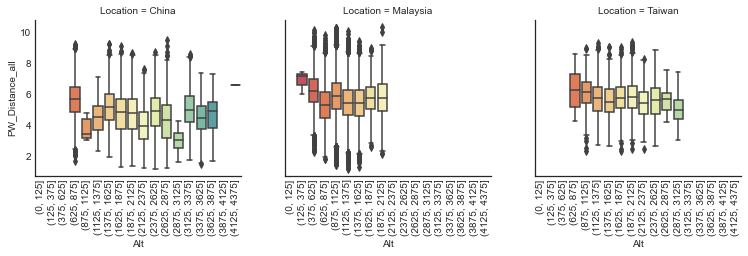

In [58]:
# plot boxplot
colname = 'PW_Distance_all'
plot_boxplot(df_pwd_exploded, colname)

##### Plot Feature space 沿緯度與海拔梯度的變化

- Distance from 0
    - 'euc'
        - interval:250m  
        ![](imgs_jupyter/Distance_0_euc_250.png)
        - interval:100m  
        ![](imgs_jupyter/Distance_0_euc_100.png)



- Pairdwise_distance all data
    - 'euc'
        - interval:250m    
        ![](imgs_jupyter/Pairedwise_distance_all_euc_250.png)
        - interval:100m  
        ![](imgs_jupyter/Pairedwise_distance_all_euc_100.png)
    
    - 'cosine'
        - Plot Pairdwise_distance all data
            - interval:250m    
            ![](imgs_jupyter/Pairedwise_distance_all_cosine_250.png)
            - interval:100m  
            ![](imgs_jupyter/Pairedwise_distance_all_cosine_100.png)


##### 迴歸分析檢視海拔與Feature Space關係
- 使用250m組距、Pairedwise Distance資料

In [59]:

def get_Alt_Mean(x:pd.Series)->pd.Series:
    x = str(x).strip('(').strip(']').strip()
    s, e = x.split(',')
    s, e = int(s.strip()), int(e.strip())
    # return np.mean(s,e).astype(np.uint16)
    return (s+e)/2

df_pwd_exploded['Alt_Mean'] = df_pwd_exploded.Alt.apply(get_Alt_Mean).astype('uint16')
print(df_pwd_exploded.dtypes)
df_pwd_exploded

Location             object
Alt                category
PW_Distance_all     float64
Alt_Mean             uint16
dtype: object


,Location,Alt,PW_Distance_all,Alt_Mean
0,China,"(625, 875]",2.008553,750
1,China,"(625, 875]",3.517336,750
2,China,"(625, 875]",3.831957,750
3,China,"(625, 875]",4.003981,750
4,China,"(625, 875]",4.691002,750
...,...,...,...,...
260836,Taiwan,"(2875, 3125]",5.141207,3000
260837,Taiwan,"(2875, 3125]",5.831884,3000
260838,Taiwan,"(2875, 3125]",5.335205,3000
260839,Taiwan,"(2875, 3125]",5.568088,3000


In [307]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression

model = LinearRegression()

df_pwd_mean = (df_pwd_exploded.set_index(['Location', 'Alt'])
               .groupby(['Location', 'Alt'])
               .mean()
               #                  .PW_Distance_all.apply(lambda x: x.mean() )
               .dropna()
               .reset_index()
               )

# X, y = df_pwd_mean.Alt_Mean.values.reshape(-1, 1), df_pwd_mean.PW_Distance_all.values


def get_reg_stat(data):
    X = data[col_x].values.reshape(-1, 1)
    y = data[col_y]
    model.fit(X, y)
    y_pred = model.predict(X).reshape(-1, 1)
    f, p = f_regression(X, y)

    R2 = r2_score(y_pred, y)
    coef_, intercept_ = model.coef_[0], model.intercept_
    df = pd.DataFrame(
        {'R2': R2, 'p': p[0], 'coef': coef_, 'intercept': intercept_}, index=[data.name])
    return df


col_x = 'Alt_Mean'
col_y = 'PW_Distance_all'
reg_stat_pwd = (df_pwd_mean.groupby(['Location'])
                .apply(get_reg_stat)
                .reset_index(level=1, drop=True)
)
reg_stat_pwd


,R2,p,coef,intercept
Location,,,,
China,-40.357449,0.599972,0.000121,4.373130
Malaysia,-1.004851,0.134363,-0.000488,6.363344
Taiwan,0.498738,0.003978,-0.000374,6.403603


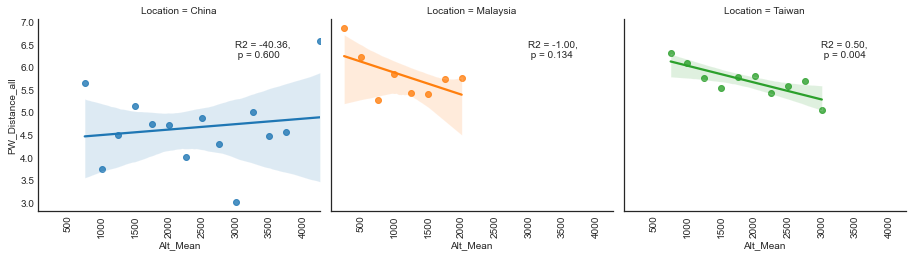

In [308]:

def plot_Regression(df_mean, col_x='Alt_Mean', col_y='PW_Distance_all'):
    g = sns.lmplot(x=col_x, y=col_y, 
                   col="Location",
                   hue="Location",
                   data=df_mean, 
                   height=3.5, aspect=1.2, 
                   x_jitter=.1,
    #                order = 2
                  )
    # g.fig.suptitle("Test",
    #               fontsize=24, fontdict={"weight": "bold"})
    # for loc_, ax in zip(locations, g.axes[0]):
    #     ax.add_title(label=loc_,
    #         fontsize=36,
    #               )
    # g.set_titles(fontsize=36)  
    g.set_xticklabels(
        # ax.get_xticklabels(), 
        rotation=90, 
        ha="center"
        );
    
    def annotate(data, col_x=col_x,y=col_y,  **kws):
        X = data[col_x].values.reshape(-1, 1)
        y = data[col_y]
        model.fit(X, y)
        y_pred = model.predict(X).reshape(-1, 1)
        f, p = f_regression(X, y)
        R2 = r2_score(y_pred, y)
    
        ax = plt.gca()
        ax.text(.7, .8,
                f'R2 = {R2:.2f},\n p = {p[0]:.3f}',
                # fontsize=12, 
                transform=ax.transAxes)
    
    g.map_dataframe(annotate)
    g.set_axis_labels(col_x, col_y)


# colname = 'PW_Distance_all'
plot_Regression(df_pwd_mean, col_x=col_x, col_y=col_y)

- 使用到原點的歐基里得距離

In [295]:
df_dis_0 = (df_dis_0.reset_index()
            .merge(
                df_TTRS_sp_based[['Species','TTRS_Elev_mid']],
                left_on='Species', right_on='Species', how='left',
              )
            .rename(columns={'TTRS_Elev_mid':'Elev_mid'})
           )
df_dis_0 

,Location,Alt,Species,Distance_0,Elev_mid
0,China,"(625, 875]",SJ_BOM01,1.722797,860.0
1,China,"(625, 875]",SJ_CRA05,2.636947,860.0
2,China,"(625, 875]",SJ_CRA06,3.482297,860.0
3,China,"(625, 875]",SJ_CRA09,2.866449,860.0
4,China,"(625, 875]",SJ_CRA13,3.273301,860.0
...,...,...,...,...,...
2427,Taiwan,"(2875, 3125]",Odontopera bilinearia subarida,4.169231,2976.5
2428,Taiwan,"(2875, 3125]",Palpita asiaticalis,3.543413,2993.0
2429,Taiwan,"(2875, 3125]",Pseudodeltote formosana,4.816611,3050.0
2430,Taiwan,"(2875, 3125]",Thyas coronata,3.578747,2993.0


In [309]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import feature_selection

model = LinearRegression()

df_dis_0_mean =  (df_dis_0
#                   .set_index(['Location', 'Alt'])
                 .groupby(['Location', 'Alt'])
                 .mean()
                 .dropna()
                 .reset_index()
                )

# X, y = df_dis_0_mean.Elev_mid.values.reshape(-1, 1), df_dis_0_mean.Distance_0.values
col_x='Elev_mid'
col_y='Distance_0'
reg_stat_dis_0 =  (df_dis_0_mean.groupby(['Location'])
                .apply(get_reg_stat)
                .reset_index(level=1, drop=True)
                )
reg_stat_dis_0

,R2,p,coef,intercept
Location,,,,
China,-68.541225,0.672562,0.000070,3.094956
Malaysia,-0.345083,0.079150,-0.000555,4.796538
Taiwan,0.624902,0.001714,-0.000285,4.636677


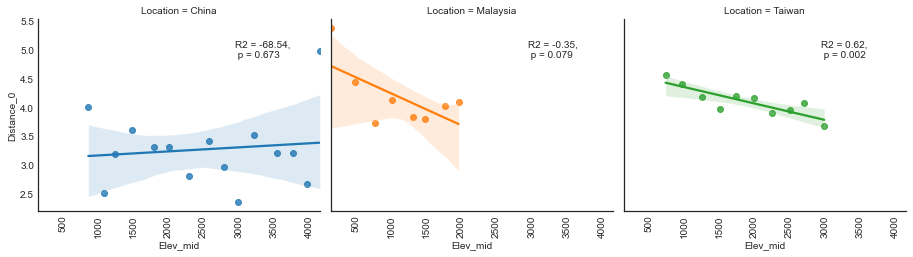

In [310]:
plot_Regression(df_dis_0_mean, col_x=col_x, col_y=col_y)

##### Plot Regression
- Distances- from 0  

    ![](imgs_jupyter/Regression_Distance_0.png)  

- Pairwise_distances- All data  

    ![](imgs_jupyter/Regression_PW_Distance_all.png)